In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import numpy as np
import seaborn as sns
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# Regression models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

In [2]:

# Load the dataset
df = pd.read_csv("/kaggle/input/modern-teen-mental-health/modern_teen_mental_health_main.csv")

#FOR RUNNING PROGRAM ON LOCAL COMPUTER, PLACE THE DATA FILE IN THE SAME FOLDER AND USE 
# THE BELOW CODE TO UPLOAD THE DATA. COMMENT THE ABOVE LINE AS WELL
#df = pd.read_csv("modern_teen_mental_health_main.csv")

# Data Cleaning and Pre processing

# Step 1: Impute missing values
# Fill missing 'ai_tool' with 'None'
df['ai_tool'] = df['ai_tool'].fillna('None')

# Fill remaining missing numerical values with column mean
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].mean())

# Step 2: Remove identifier columns
df = df.drop(columns=['student_id', 'date'])

# Step 3: One-hot encode categorical columns
#categorical_cols = df.select_dtypes(include=['object', 'bool']).columns
categorical_cols = df.select_dtypes(include=['object']).columns
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Step 4: Scale numerical features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df)
df_scaled = pd.DataFrame(scaled_features, columns=df.columns)

# Output the shape of the processed dataset
print("Processed dataset shape:", df_scaled.shape)
df.head()


Processed dataset shape: (30000, 29)


,age,mood,stress_level,sleep_hours,screen_time_hours,used_ai_today,journaled_today,meditated_today,exercised_today,social_interaction_rating,...,country_USA,grade_11th,grade_12th,grade_9th,ai_tool_EduChat,ai_tool_Gemini,ai_tool_Grammarly,ai_tool_None,ai_tool_Notion AI,ai_tool_Phind
0,15,5,5,3.6,2.1,False,False,False,True,6,...,True,True,False,False,False,False,False,True,False,False
1,15,6,4,9.1,8.8,True,True,False,True,4,...,True,True,False,False,False,False,False,False,False,True
2,15,8,2,8.5,7.8,True,False,True,False,6,...,True,True,False,False,False,False,False,False,True,False
3,15,5,6,4.9,6.1,False,True,True,False,5,...,True,True,False,False,False,False,False,True,False,False
4,15,9,1,7.7,7.5,False,True,True,False,5,...,True,True,False,False,False,False,False,True,False,False


         mood sleep_hours screen_time_hours journaled_today meditated_today  \
         mean        mean              mean            mean            mean   
cluster                                                                       
-1       5.97        6.32              6.90            0.50            0.57   
 0       5.99        6.48              7.00            0.00            0.00   
 1       6.01        6.50              6.95            1.00            0.00   
 2       6.02        6.49              6.98            0.00            1.00   
 3       6.01        6.48              7.01            0.41            0.41   
 4       5.93        6.54              6.97            0.00            1.00   

        exercised_today social_interaction_rating support_feeling  \
                   mean                      mean            mean   
cluster                                                             
-1                 0.52                      5.99            6.52   
 0          

/tmp/ipykernel_36/1229947874.py:62: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='cluster', y='stress_level', data=df_cluster, estimator=np.mean, ci=None)


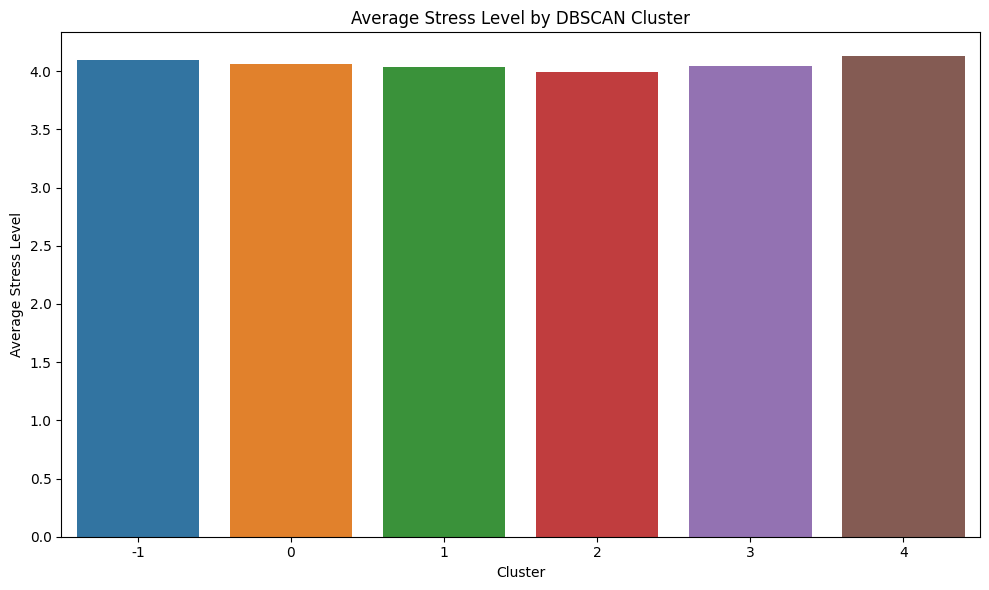

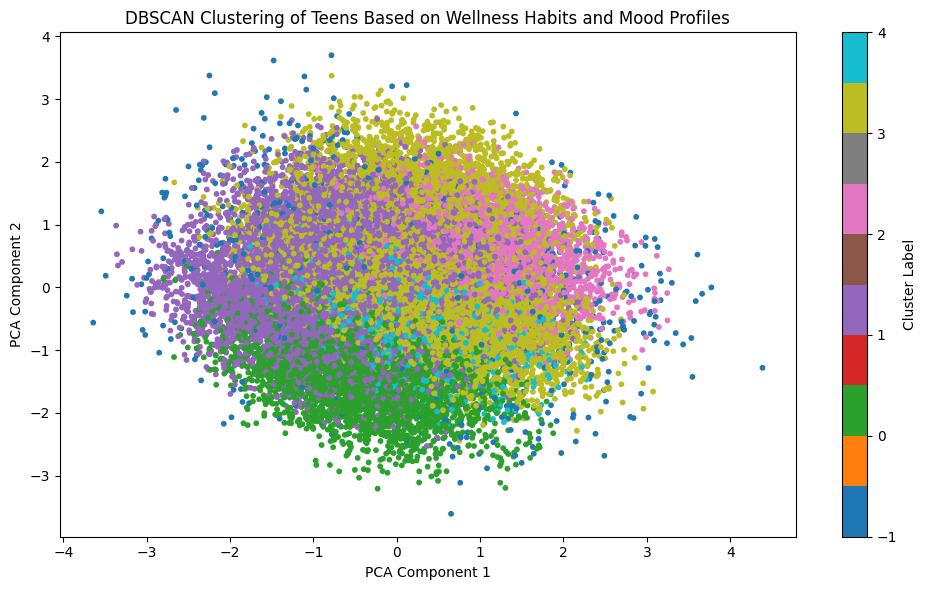

In [3]:

# Select relevant features
features = [
    'mood', 'sleep_hours', 'screen_time_hours',
    'journaled_today', 'meditated_today', 'exercised_today',
    'social_interaction_rating', 'support_feeling'
]

# Convert boolean columns to integers
df['journaled_today'] = df['journaled_today'].astype(int)
df['meditated_today'] = df['meditated_today'].astype(int)
df['exercised_today'] = df['exercised_today'].astype(int)

# Drop rows with missing values in selected features
df_cluster = df[features + ['stress_level']].dropna()

# Sample 5000 rows for DBSCAN
#df_sampled = df_cluster.sample(n=5000, random_state=42)

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster[features])

# Apply PCA to reduce dimensions
pca = PCA(n_components=6, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Apply DBSCAN
dbscan = DBSCAN(eps=0.8, min_samples=10)
df_cluster['cluster'] = dbscan.fit_predict(X_pca)
cluster = dbscan.fit_predict(X_pca)
#cluster = dbscan.fit_predict(X_scaled)
df_cluster['cluster'] = cluster
# Calculate average stress level per cluster
#stress_by_cluster = df_cluster.groupby('cluster')['stress_level'].mean().reset_index()

stress_by_cluster = df_cluster.groupby('cluster').agg({
    'mood': 'mean',
    'sleep_hours': 'mean',
    'screen_time_hours': 'mean',
    'journaled_today': 'mean',
    'meditated_today': 'mean',
    'exercised_today': 'mean',
    'social_interaction_rating': 'mean',
    'support_feeling': 'mean',
    'stress_level': ['mean', 'count']
}).round(2)
print(stress_by_cluster)

# # Plot bar graph
# plt.figure(figsize=(8, 6))
# plt.bar(stress_by_cluster['cluster'], stress_by_cluster['stress_level'], color='skyblue')
# plt.xlabel('DBSCAN Cluster')
# plt.ylabel('Average Stress Level')
# plt.title('Average Stress Level by DBSCAN Cluster')
# plt.xticks(stress_by_cluster['cluster'])
# plt.tight_layout()
# plt.savefig("stress_level_bar_plot.png")
# plt.show()

# Visualize stress level by cluster
plt.figure(figsize=(10, 6))
sns.barplot(x='cluster', y='stress_level', data=df_cluster, estimator=np.mean, ci=None)
plt.title("Average Stress Level by DBSCAN Cluster")
plt.xlabel("Cluster")
plt.ylabel("Average Stress Level")
plt.tight_layout()
plt.show()

# Plot the clusters
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster, cmap='tab10', s=10)
plt.title("DBSCAN Clustering of Teens Based on Wellness Habits and Mood Profiles")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Cluster Label")
plt.tight_layout()
plt.savefig("dbscan_clusters.png")
plt.show()


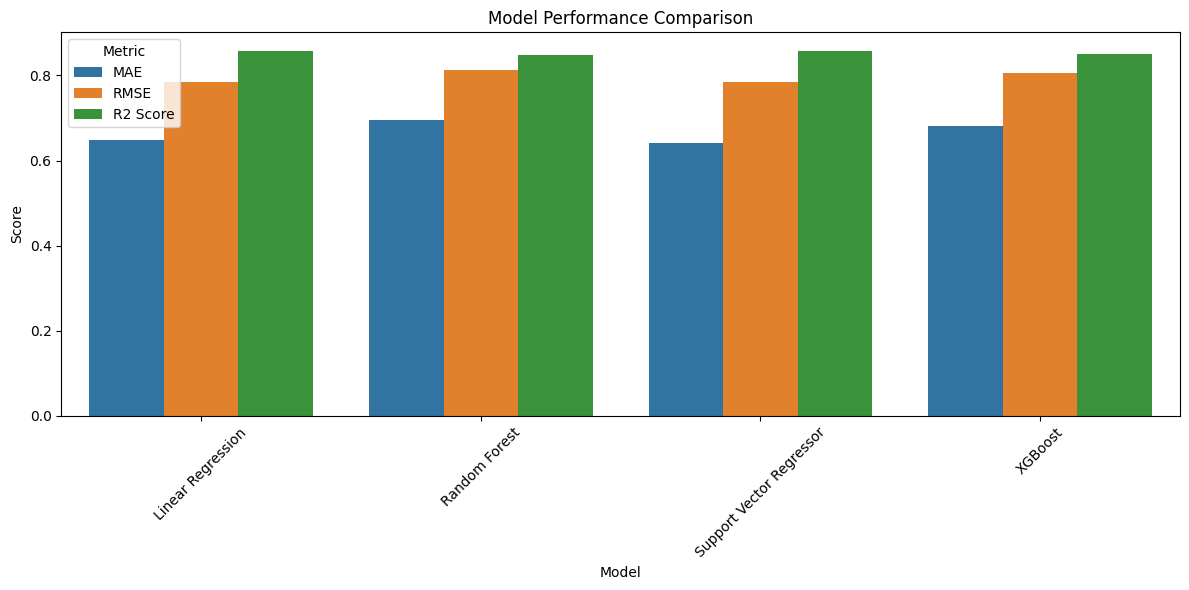

,Model,MAE,RMSE,R2 Score
0,Linear Regression,0.647607,0.784876,0.858353
1,Random Forest,0.694415,0.811977,0.848403
2,Support Vector Regressor,0.640199,0.784421,0.858518
3,XGBoost,0.681277,0.804792,0.851074


In [5]:
#RUN MODELS WITH DEFAULT PARAMETERS SETTINGS

# # Apply PCA to reduce dimensions
# pca = PCA(n_components=5, random_state=42)
# X_pca = pca.fit_transform(X_scaled)

# # Apply DBSCAN
# dbscan = DBSCAN(eps=0.8, min_samples=10)
# df_cluster['cluster'] = dbscan.fit_predict(X_pca)

# Prepare data for prediction
X = df_cluster[features + ['cluster']]
y = df_cluster['stress_level']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Support Vector Regressor': SVR(),
    'XGBoost': XGBRegressor(random_state=42, verbosity=0)
}

# Train and evaluate models
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results.append({
        'Model': name,
        'MAE': mean_absolute_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'R2 Score': r2_score(y_test, y_pred)
    })

# Create results DataFrame
results_df = pd.DataFrame(results)

# Plot comparison
plt.figure(figsize=(12, 6))
sns.barplot(data=results_df.melt(id_vars='Model', var_name='Metric', value_name='Score'),
            x='Model', y='Score', hue='Metric')
plt.title("Model Performance Comparison")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.close()


results_df



In [6]:

# Linear regression pipeline and the corresponding hyperparameters to be optimized:
ln_pl = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LinearRegression())
])

ln_params = dict(
    classifier__copy_X= [True,False],
    classifier__fit_intercept= [True,False],
    classifier__n_jobs= [1,5,None],
    classifier__positive= [True,False]
)

# Random Forest Classifier pipeline and the corresponding hyperparameters to be optimized:
rfr_pl = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestRegressor(random_state=42))
])

rfr_params = dict(
    classifier__n_estimators= [100, 200],
    #classifier__max_depth= [None, 10, 20],
    classifier__max_depth= [None, 10],
    classifier__min_samples_split= [2, 5],
    classifier__min_samples_leaf= [1, 2],
    #classifier__max_features = ['auto', 'sqrt']

)

# XGB  Classifier pipeline and the corresponding hyperparameters to be optimized:
xgb_pl = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', XGBRegressor(random_state=42, verbosity=0))
])

xgb_params = dict(
   classifier__n_estimators = [50, 100],
   classifier__max_depth = [3, 6],
   classifier__learning_rate= [0.05, 0.1]
)

# support vector regressor
svr_pl = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', SVR())
])

svr_params = dict(

    #classifier__kernel= ['rbf', 'linear'],
    classifier__kernel= ['rbf'],
    classifier__C= [0.1, 1],
    classifier__epsilon= [0.01, 1],
    #classifier__gamma= ['scale', 'auto']

)


# Define scoring metrics
scoring = {
    'MAE': 'neg_mean_absolute_error',
    'RMSE': 'neg_mean_squared_error',
    'R2': 'r2'
}




# Grid search with recall as scoring
ln_search = GridSearchCV(ln_pl, ln_params, scoring=scoring, cv=4,refit='R2',  return_train_score=True)
rfr_search = GridSearchCV(rfr_pl, rfr_params, scoring=scoring, cv=4,refit='R2',  return_train_score=True)
xgb_search = GridSearchCV(xgb_pl, xgb_params, scoring=scoring, cv=4,refit='R2',  return_train_score=True)
svr_search = GridSearchCV(svr_pl, svr_params, scoring=scoring, cv=4,refit='R2',  return_train_score=True)

# Fit models
ln_search.fit(X_train, y_train)
rfr_search.fit(X_train, y_train)
xgb_search.fit(X_train, y_train)
svr_search.fit(X_train, y_train)


GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier', SVR())]),
             param_grid={'classifier__C': [0.1, 1],
                         'classifier__epsilon': [0.01, 1],
                         'classifier__kernel': ['rbf']},
             refit='R2', return_train_score=True,
             scoring={'MAE': 'neg_mean_absolute_error', 'R2': 'r2',
                      'RMSE': 'neg_mean_squared_error'})

The model name is LN and the R² score is 0.8584
The model name is LN and the Mean absolute error is 0.6476
The model name is LN and the Root Mean Squared error is 0.6160
The model name is LN and the Best Hyperparameters: {'classifier__copy_X': True, 'classifier__fit_intercept': True, 'classifier__n_jobs': 1, 'classifier__positive': False}


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


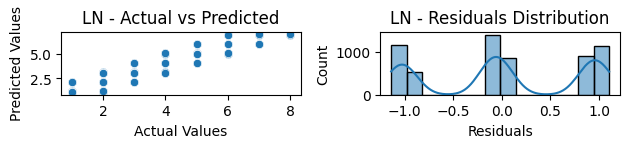

The model name is RFR and the R² score is 0.8595
The model name is RFR and the Mean absolute error is 0.6543
The model name is RFR and the Root Mean Squared error is 0.6112
The model name is RFR and the Best Hyperparameters: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


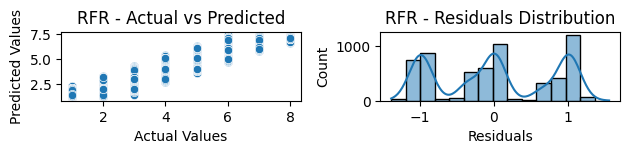

The model name is XGB and the R² score is 0.8609
The model name is XGB and the Mean absolute error is 0.6435
The model name is XGB and the Root Mean Squared error is 0.6048
The model name is XGB and the Best Hyperparameters: {'classifier__learning_rate': 0.05, 'classifier__max_depth': 3, 'classifier__n_estimators': 100}


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


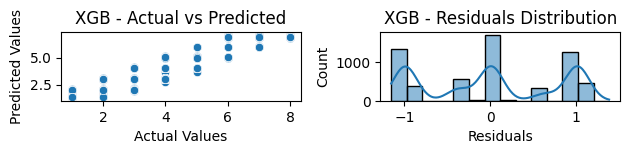

The model name is SVR and the R² score is 0.8582
The model name is SVR and the Mean absolute error is 0.6335
The model name is SVR and the Root Mean Squared error is 0.6169
The model name is SVR and the Best Hyperparameters: {'classifier__C': 1, 'classifier__epsilon': 1, 'classifier__kernel': 'rbf'}


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


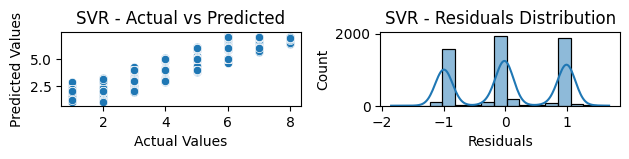

Best model based on r2: XGB
Best hyperparameters: {'classifier__learning_rate': 0.05, 'classifier__max_depth': 3, 'classifier__n_estimators': 100}


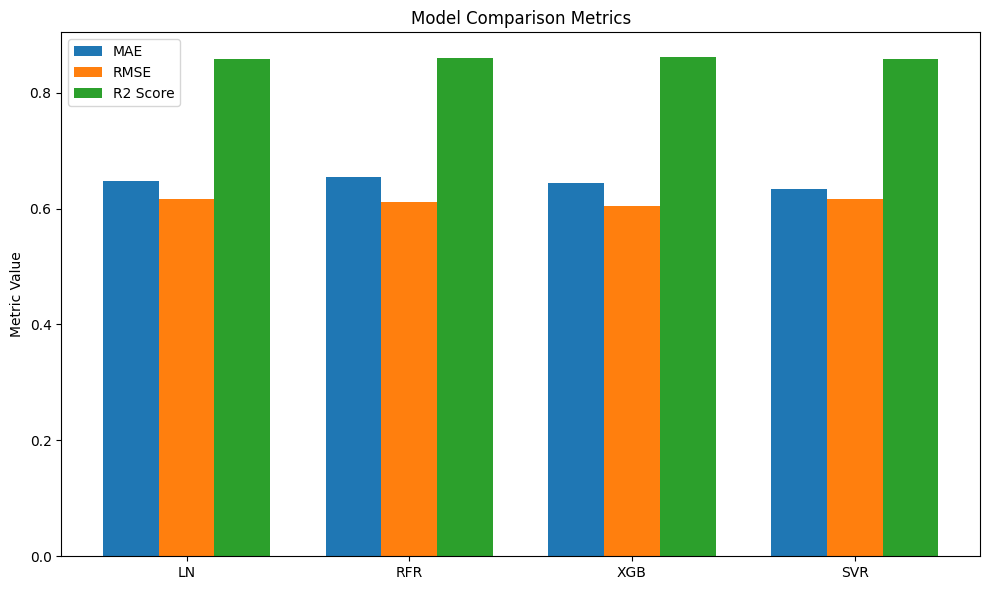

,Model,MAE,RMSE,R2,Best_Params
0,LN,0.647607,0.616031,0.858353,"{'classifier__copy_X': True, 'classifier__fit_..."
1,RFR,0.654320,0.611199,0.859464,"{'classifier__max_depth': 10, 'classifier__min..."
2,XGB,0.643549,0.604815,0.860932,"{'classifier__learning_rate': 0.05, 'classifie..."
3,SVR,0.633472,0.616913,0.858150,"{'classifier__C': 1, 'classifier__epsilon': 1,..."


In [11]:


# Evaluate best models
models = {
    'LN': ln_search,
    'RFR': rfr_search,
    'XGB': xgb_search,
    'SVR': svr_search
}
# •	Display the results of each model (including confusion matrices) and choose the best model.
results = {}
results_list=[]
# for name, search in models.items():
#     y_pred = search.predict(X_test)

#     r2 = r2_score(y_test, y_pred)
#     print(f"The model name is {name} and the R² score is {r2:.4f}")

#     #recall = recall_score(y_test, y_pred)
#     #r2 = model.score(X_test, y_test)
#     #print(f"R² Score: {r2}")
#     #print(f"The model name is {name} and the recall measure is {recall}")
#     results[name] = {'r2': r2}

num_models = len(models)

for i, (name, search) in enumerate(models.items(), 1):
    y_pred = search.predict(X_test)
    # r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    best_params = search.best_params_
    results_list.append({'Model': name, 'MAE': mae, 'RMSE': rmse, 'R2': r2,
        'Best_Params': best_params})

    results[name] = {'r2': r2,'best_params': best_params}

    print(f"The model name is {name} and the R² score is {r2:.4f}")
    print(f"The model name is {name} and the Mean absolute error is {mae:.4f}")
    print(f"The model name is {name} and the Root Mean Squared error is {rmse:.4f}")
    print(f"The model name is {name} and the Best Hyperparameters: {best_params}")

    # Scatter plot: Actual vs Predicted
    plt.subplot(num_models, 2, 2*i - 1)
    sns.scatterplot(x=y_test, y=y_pred)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(f"{name} - Actual vs Predicted")

    # Residual plot
    residuals = y_test - y_pred
    plt.subplot(num_models, 2, 2*i)
    sns.histplot(residuals, kde=True)
    plt.xlabel("Residuals")
    plt.title(f"{name} - Residuals Distribution")

    plt.tight_layout()
    plt.show()



#•	Choose the best model and display the final results of this model.

# Select best model
best_model_name = max(results, key=lambda k: results[k]['r2'])
best_model = models[best_model_name]
best_params = results[best_model_name]['best_params']

# Final evaluation
y_pred_final = best_model.predict(X_test)

# Display results
print(f"Best model based on r2: {best_model_name}")

# Create results DataFrame
results_df = pd.DataFrame(results_list)
print(f"Best hyperparameters: {best_params}")

# Plot comparison
plt.figure(figsize=(10, 6))
x = np.arange(len(results_df))
width = 0.25
plt.bar(x - width, results_df['MAE'], width=width, label='MAE')
plt.bar(x, results_df['RMSE'], width=width, label='RMSE')
plt.bar(x + width, results_df['R2'], width=width, label='R2 Score')
plt.xticks(x, results_df['Model'])
plt.ylabel("Metric Value")
plt.title("Model Comparison Metrics")
plt.legend()
plt.tight_layout()
plt.savefig("model_comparison_plot.png")
plt.show()


# Create results DataFrame
results_df #= pd.DataFrame(results_list, columns=results_list[1])



In [12]:
# Identify low stress clusters with optimal values 

print('df_cluster["cluster"].unique()=',df_cluster["cluster"].unique())
low_stress_clusters = df_cluster.groupby('cluster')['stress_level'].mean().sort_values().head(2).index.tolist()
print("low_stress_clusters:\n",low_stress_clusters)
optimal_values = df_cluster[df_cluster['cluster'].isin(low_stress_clusters)].groupby('cluster').agg({
    'mood': 'mean',
    'sleep_hours': 'mean',
    'screen_time_hours': 'mean',
    'journaled_today': 'mean',
    'meditated_today': 'mean',
    'exercised_today': 'mean',
    'social_interaction_rating': 'mean',
    'support_feeling': 'mean',
    'stress_level': ['mean', 'count']
}).round(2)

print("optimal_values of low stress clusture\n")
print(optimal_values)
# Save full cluster statistics
cluster_stats = df_cluster.groupby('cluster').agg({
    'mood': 'mean',
    'sleep_hours': 'mean',
    'screen_time_hours': 'mean',
    'journaled_today': 'mean',
    'meditated_today': 'mean',
    'exercised_today': 'mean',
    'social_interaction_rating': 'mean',
    'support_feeling': 'mean',
    'stress_level': ['mean', 'count']
}).round(2)
#cluster_stats.to_csv("cluster_statistics.csv")
print("\n")
print("cluster_stats\n")
print(cluster_stats)


df_cluster["cluster"].unique()= [ 0  1  2  3  4 -1]
low_stress_clusters:
 [2, 1]
optimal_values of low stress clusture

         mood sleep_hours screen_time_hours journaled_today meditated_today  \
         mean        mean              mean            mean            mean   
cluster                                                                       
1        6.01        6.50              6.95             1.0             0.0   
2        6.02        6.49              6.98             0.0             1.0   

        exercised_today social_interaction_rating support_feeling  \
                   mean                      mean            mean   
cluster                                                             
1                   0.4                      6.05            6.50   
2                   0.0                      6.05            6.47   

        stress_level         
                mean  count  
cluster                      
1               4.03  10354  
2               3.

low_stress_df.head()==
    mood  sleep_hours  screen_time_hours  journaled_today  meditated_today  \
2     8          8.5                7.8                0                1   
4     9          7.7                7.5                1                1   
5     7          6.6                3.4                1                0   
7     9          7.2                4.6                1                1   
9     9          6.3                7.0                0                0   

   exercised_today  social_interaction_rating  support_feeling  stress_level  \
2                0                          6                5             2   
4                0                          5                9             1   
5                1                          7                4             3   
7                0                          5                7             1   
9                0                          3                6             1   

   cluster  
2        2  
4     

<Figure size 1000x600 with 0 Axes>

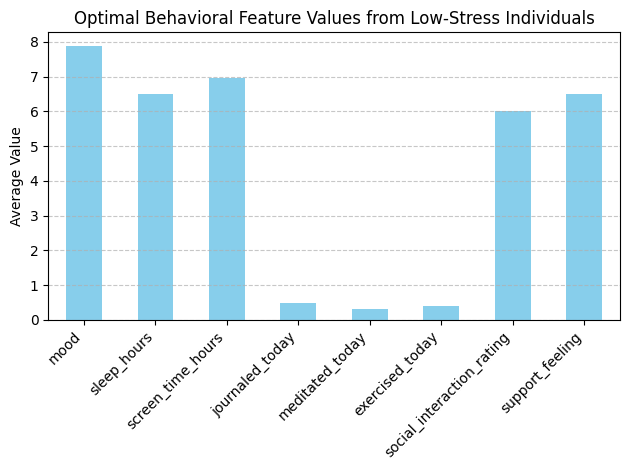

,mood,sleep_hours,screen_time_hours,journaled_today,meditated_today,exercised_today,social_interaction_rating,support_feeling,stress_level,cluster,recommendations
2308,5,5.9,7.4,1,0,1,5,8,5,1,[Engage in uplifting activities to improve moo...
22404,4,7.1,10.2,0,0,0,4,5,6,3,[Engage in uplifting activities to improve moo...
23397,7,6.5,4.8,1,0,1,4,6,2,1,[Engage in uplifting activities to improve moo...
25058,9,6.9,8.7,0,0,0,7,7,1,3,[Reduce screen time to around 6.5 hours daily....
2664,3,4.6,8.8,0,0,0,4,5,8,3,[Engage in uplifting activities to improve moo...
...,...,...,...,...,...,...,...,...,...,...,...
6778,6,10.1,8.1,0,1,0,9,7,3,2,[Engage in uplifting activities to improve moo...
25284,6,6.0,4.6,0,0,1,4,6,5,0,[Engage in uplifting activities to improve moo...
18355,7,5.5,6.5,0,0,0,3,8,3,3,[Engage in uplifting activities to improve moo...
27684,4,7.5,4.1,1,1,1,7,5,6,3,[Engage in uplifting activities to improve moo...


In [13]:
# Creating a sample application to help generate recommendations for improving mental health


# Identify low-stress entries (stress_level <= 3)
low_stress_df = df_cluster[df_cluster['stress_level'] <= 3]
print("low_stress_df.head()==\n",low_stress_df.head())
# Calculate optimal values from low-stress entries
optimal_values = low_stress_df.drop(columns='stress_level').mean().round(2)
print("optimal_values =\n",optimal_values)
print(type(optimal_values))
# Define recommendation logic based on deviations from optimal values
def generate_recommendation(row, optimal):
    suggestions = []
    if row['mood'] < optimal['mood']:
        suggestions.append("Engage in uplifting activities to improve mood.")
    if row['sleep_hours'] < optimal['sleep_hours']:
        suggestions.append("Aim for more consistent sleep (~6.5 hours).")
    if row['screen_time_hours'] > optimal['screen_time_hours']:
        suggestions.append("Reduce screen time to around 6.5 hours daily.")
    if row['journaled_today'] < optimal['journaled_today']:
        suggestions.append("Try journaling to reflect and manage emotions.")
    if row['meditated_today'] < optimal['meditated_today']:
        suggestions.append("Incorporate short meditation sessions into your routine.")
    if row['exercised_today'] < optimal['exercised_today']:
        suggestions.append("Engage in light physical activity regularly.")
    if row['social_interaction_rating'] < optimal['social_interaction_rating']:
        suggestions.append("Connect with friends or peers to boost social engagement.")
    if row['support_feeling'] < optimal['support_feeling']:
        suggestions.append("Seek emotional support from trusted individuals.")
    return suggestions

# Apply recommendation system to a sample of students
sample_students = df_cluster.sample(n=5000, random_state=42)
recommendations = sample_students.apply(lambda row: generate_recommendation(row, optimal_values), axis=1)

# Combine sample data with recommendations
recommendation_output = sample_students.copy()
recommendation_output['recommendations'] = recommendations

# Plotting the bar chart

#optimal_df = pd.DataFrame.from_dict(optimal_values, orient='index', columns=['Optimal Value'])
optimal_df = pd.DataFrame(optimal_values)
optimal_df = optimal_df.drop("cluster")
plt.figure(figsize=(10, 6))
optimal_df.plot(kind='bar', legend=False, color='skyblue')
plt.title('Optimal Behavioral Feature Values from Low-Stress Individuals')
plt.ylabel('Average Value')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

# Display the recommendation output
recommendation_output[['mood', 'sleep_hours', 'screen_time_hours',
                       'journaled_today', 'meditated_today', 'exercised_today',
                       'social_interaction_rating', 'support_feeling',
                       'stress_level','cluster', 'recommendations']]






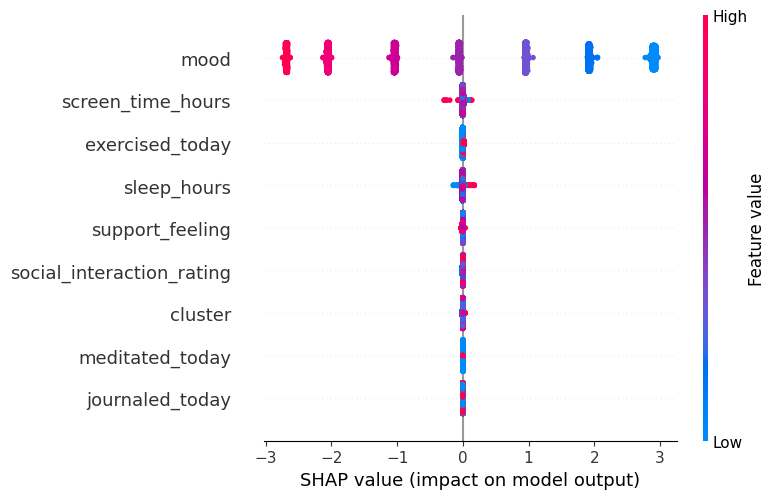

<Figure size 640x480 with 0 Axes>

In [14]:
# SHAP analysis to find out the feature impacting the output the most.
import shap


# Get the best pipeline from grid search
best_xgb_pipeline = xgb_search.best_estimator_

# Extract the trained XGBRegressor model
xgb_model = best_xgb_pipeline.named_steps['classifier']

# Extract the scaled training data
X_train_scaled = best_xgb_pipeline.named_steps['scaler'].transform(X_train)

# Create SHAP explainer
explainer = shap.Explainer(xgb_model)

# Compute SHAP values
shap_values = explainer(X_train_scaled)

# Plot SHAP summary
shap.summary_plot(shap_values, X_train_scaled, feature_names=X_train.columns)


# # SHAP analysis
# explainer = shap.Explainer(xgb_search)
# shap_values = explainer(X_train)

# # Plot SHAP summary using scaled training data
# plt.figure(figsize=(10, 6))
# shap.summary_plot(shap_values, X_train, feature_names=features, show=False)
plt.tight_layout()
plt.show()




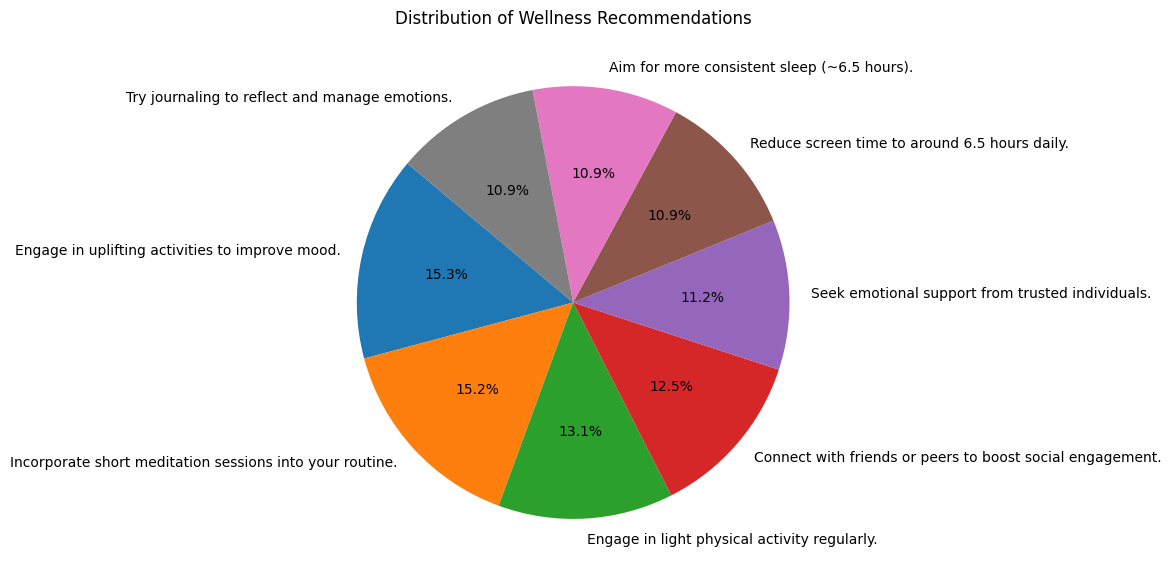

{'Engage in uplifting activities to improve mood.': 15.276877188432108,
 'Aim for more consistent sleep (~6.5 hours).': 10.89352872519777,
 'Reduce screen time to around 6.5 hours daily.': 10.936757013789824,
 'Incorporate short meditation sessions into your routine.': 15.242294557558466,
 'Connect with friends or peers to boost social engagement.': 12.488652574244586,
 'Try journaling to reflect and manage emotions.': 10.880560238620154,
 'Engage in light physical activity regularly.': 13.085202956814939,
 'Seek emotional support from trusted individuals.': 11.196126745342152}

In [15]:
# Plot the output of the usage application created above

from collections import Counter
# Flatten all recommendations into a single list
all_recommendations = [rec for sublist in recommendations for rec in sublist]

# Count frequency of each recommendation type
recommendation_counts = pd.Series(all_recommendations).value_counts()

# Plot pie chart of recommendation types
plt.figure(figsize=(10, 8))
plt.pie(recommendation_counts, labels=recommendation_counts.index, autopct='%1.1f%%', startangle=140)
plt.title("Distribution of Wellness Recommendations")
plt.tight_layout()
plt.show()


# Count frequency of each recommendation
recommendation_counts = Counter(all_recommendations)

# Calculate percentage distribution
total_recommendations = sum(recommendation_counts.values())
recommendation_percentages = {k: (v / total_recommendations) * 100 for k, v in recommendation_counts.items()}

# Display the percentage distribution
recommendation_percentages
